In [1]:
print("all ok")

all ok


In [2]:
import sys, os

# Get project root — one level up from 'research_and_analyst'
project_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))
sys.path.append(project_root)

print("Project root added to path:", project_root)

Project root added to path: c:\Users\tessd\ARRG2026\automated-research-report-generation


In [3]:
from research_and_analyst.utils.model_loader import ModelLoader

In [4]:
model_loader = ModelLoader()

{"timestamp": "2026-01-29T16:31:11.990042Z", "level": "info", "event": "OPENAI_API_KEY loaded from environment"}
{"timestamp": "2026-01-29T16:31:11.991991Z", "level": "warning", "event": "GOOGLE_API_KEY is missing from environment"}
{"timestamp": "2026-01-29T16:31:11.991991Z", "level": "warning", "event": "GROQ_API_KEY is missing from environment"}
{"config_keys": ["embedding_model", "retriever", "llm"], "timestamp": "2026-01-29T16:31:11.994239Z", "level": "info", "event": "YAML config loaded"}


In [5]:
llm=model_loader.load_llm()

{"provider": "openai", "model": "gpt-5.2", "timestamp": "2026-01-29T16:31:14.320896Z", "level": "info", "event": "Loading LLM"}


In [6]:
llm.invoke("hi").content

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


'Hi—what can I help you with today?'

In [7]:
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

In [8]:
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import AIMessage,HumanMessage , SystemMessage
from langgraph.checkpoint.memory import MemorySaver

#health

Analyst(
        name="Dr. Neha Patel",
        role="Medical Data Scientist",
        affiliation="Stanford Medicine",
        description="Focuses on predictive models for patient outcomes."
        ),

Analyst(
    name="Dr. Arun Verma",
    role="Ethics Researcher",
    affiliation="WHO",
    description="Explores ethical implications of AI in diagnostics."
),
Analyst(
    name="Ms. Priya Sharma",
    role="Policy Analyst",
    affiliation="Ministry of Health",
    description="Investigates AI policy and compliance frameworks."
)

In [9]:
class Analyst(BaseModel):
    name: str = Field(description="Name of the analyst.")
    role: str = Field(description="Role of the analyst in the context of the topic.")
    affiliation: str = Field(description="Primary affiliation of the analyst.")
    description: str = Field(description="Description of the analyst focus, concerns, and motives.")
    
    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"
    

In [10]:
Analyst(
    name="Tess Aquino",
    role="genai engineer",
    affiliation="AI Research LAB",
    description="I am genai developer as well as mentor"
    )

Analyst(name='Tess Aquino', role='genai engineer', affiliation='AI Research LAB', description='I am genai developer as well as mentor')

In [11]:
analyst = Analyst(
    name="Tess Aquino",
    role="genai engineer",
    affiliation="AI Research LAB",
    description="I am genai developer as well as mentor"
    )

In [12]:
analyst.name

'Tess Aquino'

In [13]:
analyst.role

'genai engineer'

In [14]:
analyst.affiliation

'AI Research LAB'

In [15]:
print(analyst.persona)

Name: Tess Aquino
Role: genai engineer
Affiliation: AI Research LAB
Description: I am genai developer as well as mentor



In [16]:
class Perspectives(BaseModel):
       analysts: List[Analyst] = Field(description="Comprehensive list of analysts with their roles and affiliations.")

In [17]:
class GenerateAnalystsState(TypedDict):
    topic: str #research topic
    max_analysts: int # number of analyst
    human_analyst_feedback: str # Human feedback
    analysts: List[Analyst] # Analyst asking questions
    

In [18]:
GenerateAnalystsState(
    topic = "finance",
    max_analysts= 5,
    human_analyst_feedback= "give the real info",  
)

{'topic': 'finance',
 'max_analysts': 5,
 'human_analyst_feedback': 'give the real info'}

In [19]:
Analyst(
        name="Dr. Neha Patel",
        role="Medical Data Scientist",
        affiliation="Stanford Medicine",
        description="Focuses on predictive models for patient outcomes."
    ),

(Analyst(name='Dr. Neha Patel', role='Medical Data Scientist', affiliation='Stanford Medicine', description='Focuses on predictive models for patient outcomes.'),)

In [20]:
analyst_instructions="""You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:

1. First, review the research topic:
{topic}
        
2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: 
        
{human_analyst_feedback}
    
3. Determine the most interesting themes based upon documents and / or feedback above.
                    
4. Pick the top {max_analysts} themes.

5. Assign one analyst to each theme."""

In [21]:
print([analyst_instructions.format(
        topic="education",
        max_analysts=4,
        human_analyst_feedback="please exaplain only on AI"
        
        )] + ["Generate the set of analysts."])

['You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:\n\n1. First, review the research topic:\neducation\n\n2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: \n\nplease exaplain only on AI\n\n3. Determine the most interesting themes based upon documents and / or feedback above.\n\n4. Pick the top 4 themes.\n\n5. Assign one analyst to each theme.', 'Generate the set of analysts.']


['You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:\n\n1. First, review the research topic:\neducation\n\n2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: \n\nplease exaplain only on AI\n\n3. Determine the most interesting themes based upon documents and / or feedback above.\n\n4. Pick the top 4 themes.\n\n5. Assign one analyst to each theme.', 'Generate the set of analysts.']

In [22]:
def create_analyst(state:GenerateAnalystsState):
    """
    it is creating my analyst
    
    """
    topic = state["topic"]
    max_analysts = state["max_analysts"]
    human_analyst_feedback = state.get("human_analyst_feedback","")
    
    structured_llm = llm.with_structured_output(Perspectives)
    
    system_messages = analyst_instructions.format(
        topic=topic,
        max_analysts=max_analysts,
        human_analyst_feedback=human_analyst_feedback
        
        )
    analysts = structured_llm.invoke([SystemMessage(content=system_messages)]+ [HumanMessage(content="Generate the set of analysts.")])
    
    # Write the list of analysis to state
    return {"analysts": analysts.analysts}
    

In [23]:
create_analyst(
    {'topic': 'health',
    'max_analysts': 2,
    'human_analyst_feedback': 'give the real info'}
    )

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'analysts': [Analyst(name='Dr. Maya Chen', role='Evidence-Based Clinical Analyst (Primary Care & Preventive Medicine)', affiliation='Academic Medical Center / Public Health Clinic', description='Focuses on translating health questions into actionable, evidence-based guidance grounded in high-quality sources (systematic reviews, major clinical guidelines). Prioritizes benefits vs. harms, absolute risk, and real-world adherence. Flags misinformation, overhyped supplements, and unsafe advice; highlights when a clinician visit is warranted and what questions/labs actually matter.'),
  Analyst(name='Samuel Ortiz, MPH', role='Health Systems & Policy Analyst (Access, Equity, and Outcomes)', affiliation='Health Policy Institute / Community Health Coalition', description="Examines how access, cost, insurance design, and social determinants shape health outcomes. Concentrates on practical pathways to care, screening uptake, medication affordability, and population-level interventions with measu

In [24]:
def human_feedback(state):
    """ No-op node that should be interrupted on """
    pass

In [25]:
def should_continue(state):
    feedback = (state.get("human_analyst_feedback") or "").strip().lower()
    if feedback and feedback not in ["", "none", "skip", "done", "continue"]:
        return "create_analyst"
    return END


In [26]:
from IPython.display import Image, display

## First Workflow

In [27]:
builder = StateGraph(GenerateAnalystsState)

In [28]:
builder.add_node("create_analyst",create_analyst)
builder.add_node("human_feedback", human_feedback)

In [29]:
builder.add_edge(START,"create_analyst")
builder.add_edge("create_analyst", "human_feedback")
builder.add_conditional_edges("human_feedback",
                        should_continue,
                        ["create_analyst",
                        END])

In [30]:
memory = MemorySaver()

In [31]:
graph = builder.compile(interrupt_before= ["human_feedback"],checkpointer= memory)

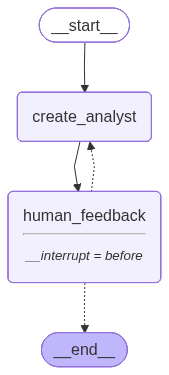

In [32]:
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [33]:
topic = "the benefits of adopting Langgraph as an agent framework"

In [34]:
max_analysts = 4

In [35]:
thread =  {"configurable":{"thread_id":1}}

In [36]:
for event in graph.stream({"topic":topic,
            "max_analysts":max_analysts},
            thread,
            stream_mode= "values"):
    analysts = event.get('analysts', '')
    
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  
            
        

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Name: Maya Chen
Affiliation: Enterprise AI Platform Team
Role: Agent Platform Architect
Description: Focuses on whether LangGraph’s graph-based agent modeling improves system reliability and maintainability over ad-hoc orchestration. Evaluates benefits like explicit state management, deterministic control flow, testability, and support for complex multi-step, multi-agent workflows. Primary concern is long-term operability: debugging, versioning, reproducible runs, and reducing ‘agent spaghetti’ as applications scale.
--------------------------------------------------
Name: Rafael Ortiz
Affiliation: Cloud Operations / SRE Organization
Role: MLOps & Observability Lead
Description: Assesses LangGraph from an operational excellence lens: tracing, monitoring, evaluation hooks, failure handling, and incident response. Looks for benefits such as better introspection into agent decisions, structured checkpoints, retry policies, and clearer run lineage for audits. Motive is minimizing productio

In [37]:
state = graph.get_state(thread)

In [38]:
state

StateSnapshot(values={'topic': 'the benefits of adopting Langgraph as an agent framework', 'max_analysts': 4, 'analysts': [Analyst(name='Maya Chen', role='Agent Platform Architect', affiliation='Enterprise AI Platform Team', description='Focuses on whether LangGraph’s graph-based agent modeling improves system reliability and maintainability over ad-hoc orchestration. Evaluates benefits like explicit state management, deterministic control flow, testability, and support for complex multi-step, multi-agent workflows. Primary concern is long-term operability: debugging, versioning, reproducible runs, and reducing ‘agent spaghetti’ as applications scale.'), Analyst(name='Rafael Ortiz', role='MLOps & Observability Lead', affiliation='Cloud Operations / SRE Organization', description='Assesses LangGraph from an operational excellence lens: tracing, monitoring, evaluation hooks, failure handling, and incident response. Looks for benefits such as better introspection into agent decisions, str

In [39]:
state.values

{'topic': 'the benefits of adopting Langgraph as an agent framework',
 'max_analysts': 4,
 'analysts': [Analyst(name='Maya Chen', role='Agent Platform Architect', affiliation='Enterprise AI Platform Team', description='Focuses on whether LangGraph’s graph-based agent modeling improves system reliability and maintainability over ad-hoc orchestration. Evaluates benefits like explicit state management, deterministic control flow, testability, and support for complex multi-step, multi-agent workflows. Primary concern is long-term operability: debugging, versioning, reproducible runs, and reducing ‘agent spaghetti’ as applications scale.'),
  Analyst(name='Rafael Ortiz', role='MLOps & Observability Lead', affiliation='Cloud Operations / SRE Organization', description='Assesses LangGraph from an operational excellence lens: tracing, monitoring, evaluation hooks, failure handling, and incident response. Looks for benefits such as better introspection into agent decisions, structured checkpoin

In [40]:
state.next

('human_feedback',)

In [41]:
memory.storage.items()

dict_items([('1', defaultdict(<class 'dict'>, {'': {'1f0fd302-62bd-6755-bfff-1c13888beff6': (('msgpack', b'\x86\xa1v\x04\xa2ts\xd9 2026-01-29T16:32:48.915029+00:00\xa2id\xd9$1f0fd302-62bd-6755-bfff-1c13888beff6\xb0channel_versions\x81\xa9__start__\xd9400000000000000000000000000000001.0.46770775529042263\xadversions_seen\x81\xa9__input__\x80\xb0updated_channels\x91\xa9__start__'), ('msgpack', b'\x83\xa6source\xa5input\xa4step\xff\xa7parents\x80'), None), '1f0fd302-62c0-647f-8000-dfeee9a65a20': (('msgpack', b'\x86\xa1v\x04\xa2ts\xd9 2026-01-29T16:32:48.916185+00:00\xa2id\xd9$1f0fd302-62c0-647f-8000-dfeee9a65a20\xb0channel_versions\x84\xa9__start__\xd9300000000000000000000000000000002.0.5734935757994772\xa5topic\xd9300000000000000000000000000000002.0.5734935757994772\xacmax_analysts\xd9300000000000000000000000000000002.0.5734935757994772\xb8branch:to:create_analyst\xd9300000000000000000000000000000002.0.5734935757994772\xadversions_seen\x82\xa9__input__\x80\xa9__start__\x81\xa9__start__\x

In [ ]:
# import msgpack

# for thread_id, ns_dict in memory.storage.items():
#     print(f"\n Thread ID: {thread_id}")
    
#     # ns_dict = defaultdict(dict, {'': {...}})
#     for ns, ckpts in ns_dict.items():
#         print(f"  Namespace: '{ns}'")
        
#         # ckpts = dict of {checkpoint_id: (packed_values, packed_metadata, parent_id)}
#         for ckpt_id, (packed_values, packed_metadata, parent_id) in ckpts.items():
#             print(f"    Checkpoint ID: {ckpt_id}")
            
#             # Decode msgpack binary
#             values = msgpack.unpackb(packed_values[1], raw=False)
#             meta = msgpack.unpackb(packed_metadata[1], raw=False)
            
#             print(f"    Values keys: {list(values.keys())}")
#             print(f"    Parent ID: {parent_id}")
#             print(f"    Metadata: {meta}")
#             print("-" * 80)


In [42]:
state.config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0fd302-b05b-632d-8001-c526f35efdcc'}}

In [43]:
graph.update_state(thread,
                {"human_analyst_feedback":"add something from the startup perspective and focus on the latest enterprise application"},as_node="human_feedback"
                )

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0fd303-651d-6a9f-8002-deca5c6253e6'}}

In [44]:
for event in graph.stream({"topic":topic,
            "max_analysts":max_analysts},
            thread,
            stream_mode= "values"):
    analysts = event.get('analysts', '')
    
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

Name: Maya Chen
Affiliation: Enterprise AI Platform Team
Role: Agent Platform Architect
Description: Focuses on whether LangGraph’s graph-based agent modeling improves system reliability and maintainability over ad-hoc orchestration. Evaluates benefits like explicit state management, deterministic control flow, testability, and support for complex multi-step, multi-agent workflows. Primary concern is long-term operability: debugging, versioning, reproducible runs, and reducing ‘agent spaghetti’ as applications scale.
--------------------------------------------------
Name: Rafael Ortiz
Affiliation: Cloud Operations / SRE Organization
Role: MLOps & Observability Lead
Description: Assesses LangGraph from an operational excellence lens: tracing, monitoring, evaluation hooks, failure handling, and incident response. Looks for benefits such as better introspection into agent decisions, structured checkpoints, retry policies, and clearer run lineage for audits. Motive is minimizing productio

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Name: Maya Chen
Affiliation: Global financial services enterprise (CDAO/Platform Engineering org)
Role: Enterprise AI Platform Architect
Description: Evaluates LangGraph for enterprise-grade agent orchestration: reliability, determinism vs. autonomy, long-running workflows, human-in-the-loop approvals, auditability, and governance. Focuses on integrating with existing MLOps/LLMOps, IAM, secrets, observability, and SDLC controls, and on reducing operational risk while scaling agentic applications across business units.
--------------------------------------------------
Name: Ravi Patel
Affiliation: Seed-to-Series A B2B SaaS startup
Role: Startup CTO / Product-Engineering Lead
Description: Assesses LangGraph from a startup perspective: speed-to-market, developer ergonomics, maintainability, and cost. Looks for clear patterns to ship production agents quickly (tooling, retries, fallbacks, evals), while avoiding lock-in and minimizing complexity. Motivated by building differentiated agent 

In [45]:
state = graph.get_state(thread)

In [46]:
state

StateSnapshot(values={'topic': 'the benefits of adopting Langgraph as an agent framework', 'max_analysts': 4, 'human_analyst_feedback': 'add something from the startup perspective and focus on the latest enterprise application', 'analysts': [Analyst(name='Maya Chen', role='Enterprise AI Platform Architect', affiliation='Global financial services enterprise (CDAO/Platform Engineering org)', description='Evaluates LangGraph for enterprise-grade agent orchestration: reliability, determinism vs. autonomy, long-running workflows, human-in-the-loop approvals, auditability, and governance. Focuses on integrating with existing MLOps/LLMOps, IAM, secrets, observability, and SDLC controls, and on reducing operational risk while scaling agentic applications across business units.'), Analyst(name='Ravi Patel', role='Startup CTO / Product-Engineering Lead', affiliation='Seed-to-Series A B2B SaaS startup', description='Assesses LangGraph from a startup perspective: speed-to-market, developer ergonom

In [47]:
state.next

('human_feedback',)

In [48]:
state.values

{'topic': 'the benefits of adopting Langgraph as an agent framework',
 'max_analysts': 4,
 'human_analyst_feedback': 'add something from the startup perspective and focus on the latest enterprise application',
 'analysts': [Analyst(name='Maya Chen', role='Enterprise AI Platform Architect', affiliation='Global financial services enterprise (CDAO/Platform Engineering org)', description='Evaluates LangGraph for enterprise-grade agent orchestration: reliability, determinism vs. autonomy, long-running workflows, human-in-the-loop approvals, auditability, and governance. Focuses on integrating with existing MLOps/LLMOps, IAM, secrets, observability, and SDLC controls, and on reducing operational risk while scaling agentic applications across business units.'),
  Analyst(name='Ravi Patel', role='Startup CTO / Product-Engineering Lead', affiliation='Seed-to-Series A B2B SaaS startup', description='Assesses LangGraph from a startup perspective: speed-to-market, developer ergonomics, maintainabi

In [ ]:
# import msgpack

# def get_all_checkpoints(memory, thread_id="1"):
#     """Return all checkpoints in chronological order for a thread."""
#     checkpoints = []
#     ns_dict = memory.storage.get(thread_id, {})
#     if "" not in ns_dict:
#         return []

#     for ckpt_id, (packed_values, packed_meta, parent_id) in ns_dict[""].items():
#         values = msgpack.unpackb(packed_values[1], raw=False)
#         meta = msgpack.unpackb(packed_meta[1], raw=False)
#         checkpoints.append({
#             "id": ckpt_id,
#             "parent": parent_id,
#             "topic": values.get("topic"),
#             "feedback": values.get("human_analyst_feedback"),
#             "analyst_count": len(values.get("analysts", [])),
#             "analysts": [a.model_dump() for a in values.get("analysts", [])],
#             "step": meta.get("step"),
#             "created_at": values.get("ts", None)
#         })
#     return checkpoints

# # Fetch all
# history = get_all_checkpoints(memory)

# # Sort by step (to get chronological order)
# history = sorted(history, key=lambda x: (x["step"] or 0))

# # Display neatly
# for h in history:
#     print(f"\nSTEP {h['step']} | CHECKPOINT {h['id']}")
#     print(f"Parent: {h['parent']}")
#     print(f"Topic: {h['topic']}")
#     print(f"Feedback: {h['feedback']}")
#     print(f"Analysts generated: {h['analyst_count']}")
#     print("-"*100)


In [49]:
# If we are satisfied, then we simply supply no feedback
further_feedack = ""

In [50]:
# 1) Get the latest state (you're paused at 'human_feedback')
state = graph.get_state(thread)

# 2) Use the exact config from that state (it already has thread_id, checkpoint_ns, checkpoint_id)
cfg = state.config

In [51]:
# 3) Update feedback at the 'human_feedback' node
#    Tip: if your TypedDict says `human_analyst_feedback: str`, prefer "" (empty string) over None
graph.update_state(cfg, {"human_analyst_feedback": ""}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0fd305-1e4e-6a26-8006-04a43adf6445'}}

In [52]:
# 4) Verify it moved to END
final_state = graph.get_state(thread)
print(final_state.next)  # should be (END,)


()


In [53]:
analysts = final_state.values.get('analysts')

In [54]:
analysts

[Analyst(name='Maya Chen', role='Enterprise AI Platform Architect', affiliation='Global financial services enterprise (CDAO/Platform Engineering org)', description='Evaluates LangGraph for enterprise-grade agent orchestration: reliability, determinism vs. autonomy, long-running workflows, human-in-the-loop approvals, auditability, and governance. Focuses on integrating with existing MLOps/LLMOps, IAM, secrets, observability, and SDLC controls, and on reducing operational risk while scaling agentic applications across business units.'),
 Analyst(name='Ravi Patel', role='Startup CTO / Product-Engineering Lead', affiliation='Seed-to-Series A B2B SaaS startup', description='Assesses LangGraph from a startup perspective: speed-to-market, developer ergonomics, maintainability, and cost. Looks for clear patterns to ship production agents quickly (tooling, retries, fallbacks, evals), while avoiding lock-in and minimizing complexity. Motivated by building differentiated agent features with a sm

In [55]:
for analyst in analysts:
    print(f"Name: {analyst.name}")
    print(f"Affiliation: {analyst.affiliation}")
    print(f"Role: {analyst.role}")
    print(f"Description: {analyst.description}")
    print("-" * 50) 

Name: Maya Chen
Affiliation: Global financial services enterprise (CDAO/Platform Engineering org)
Role: Enterprise AI Platform Architect
Description: Evaluates LangGraph for enterprise-grade agent orchestration: reliability, determinism vs. autonomy, long-running workflows, human-in-the-loop approvals, auditability, and governance. Focuses on integrating with existing MLOps/LLMOps, IAM, secrets, observability, and SDLC controls, and on reducing operational risk while scaling agentic applications across business units.
--------------------------------------------------
Name: Ravi Patel
Affiliation: Seed-to-Series A B2B SaaS startup
Role: Startup CTO / Product-Engineering Lead
Description: Assesses LangGraph from a startup perspective: speed-to-market, developer ergonomics, maintainability, and cost. Looks for clear patterns to ship production agents quickly (tooling, retries, fallbacks, evals), while avoiding lock-in and minimizing complexity. Motivated by building differentiated agent 

In [56]:
from langchain_community.document_loaders import WikipediaLoader

docs = WikipediaLoader(query="LangGraph").load()
print(docs[0].page_content[:500])

LangChain is a software framework that helps facilitate the integration of large language models (LLMs) into applications. As a language model integration framework, LangChain's use-cases largely overlap with those of language models in general, including document analysis and summarization, chatbots, and code analysis.


== History ==
LangChain was launched in October 2022 as an open source project by Harrison Chase, while working at machine learning startup Robust Intelligence. In April 2023, 


## Second Workflow

In [57]:
from langchain_community.tools.tavily_search import TavilySearchResults

In [58]:
from dotenv import load_dotenv
load_dotenv()
import os
tavily_api_key = os.getenv("TAVILY_API_KEY")

In [59]:
tavily_search = TavilySearchResults(tavily_api_key=tavily_api_key)

C:\Users\tessd\AppData\Local\Temp\ipykernel_18420\1029971610.py:1: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  tavily_search = TavilySearchResults(tavily_api_key=tavily_api_key)


In [60]:
tavily_search.invoke("langgraph")

[{'title': 'LangGraph overview - Docs by LangChain',
  'url': 'https://docs.langchain.com/oss/python/langgraph/overview',
  'content': 'Trusted by companies shaping the future of agents— including Klarna, Replit, Elastic, and more— LangGraph is a low-level orchestration framework and runtime for building, managing, and deploying long-running, stateful agents.LangGraph is very low-level, and focused entirely on agent orchestration. Before using LangGraph, we recommend you familiarize yourself with some of the components used to build agents, starting with models and tools.We will commonly use LangChain components throughout the documentation to integrate models and tools, but you don’t need to use LangChain to use LangGraph. If you are just getting started with agents or want a higher-level abstraction, we recommend you use LangChain’s agents that provide pre-built architectures for common LLM and tool-calling [...] LangGraph provides low-level supporting infrastructure for _any_ long-r

In [61]:
from langchain_community.document_loaders import WikipediaLoader

docs = WikipediaLoader(query="LangGraph").load()
print(docs[0].page_content[:500])

LangChain is a software framework that helps facilitate the integration of large language models (LLMs) into applications. As a language model integration framework, LangChain's use-cases largely overlap with those of language models in general, including document analysis and summarization, chatbots, and code analysis.


== History ==
LangChain was launched in October 2022 as an open source project by Harrison Chase, while working at machine learning startup Robust Intelligence. In April 2023, 


LangChain is a software framework that helps facilitate the integration of large language models (LLMs) into applications. As a language model integration framework, LangChain's use-cases largely overlap with those of language models in general, including document analysis and summarization, chatbots, and code analysis.


== History ==
LangChain was launched in October 2022 as an open source project by Harrison Chase, while working at machine learning startup Robust Intelligence. In April 2023, 

In [62]:
import operator
from typing import  Annotated
from langgraph.graph import MessagesState

class InterviewState(MessagesState):
    max_num_turns: int # Number turns of conversation
    context: Annotated[list, operator.add] # Source docs
    analyst: Analyst # Analyst asking questions
    interview: str # Interview transcript
    sections: list # Final key we duplicate in outer state for Send() API

class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Search query for retrieval.")

In [63]:
question_instructions = """You are an analyst tasked with interviewing an expert to learn about a specific topic. 

Your goal is boil down to interesting and specific insights related to your topic.

1. Interesting: Insights that people will find surprising or non-obvious.
        
2. Specific: Insights that avoid generalities and include specific examples from the expert.

Here is your topic of focus and set of goals: {goals}
        
Begin by introducing yourself using a name that fits your persona, and then ask your question.

Continue to ask questions to drill down and refine your understanding of the topic.
        
When you are satisfied with your understanding, complete the interview with: "Thank you so much for your help!"

Remember to stay in character throughout your response, reflecting the persona and goals provided to you."""

In [64]:
print(analyst.persona)

Name: Jordan Okafor
Role: Applied AI Product Manager (Enterprise Applications)
Affiliation: Enterprise software vendor / internal AI apps team
Description: Focuses on the latest enterprise application patterns enabled by LangGraph: multi-agent collaboration, workflow automation across systems of record (CRM/ERP/ITSM), customer support copilots, research/analysis agents, and back-office process automation. Judges benefits in terms of time-to-value, reliability of outcomes, user trust (explanations/trace views), and how graph-based design maps to real business processes and SLAs.



In [65]:
question_instructions.format(goals = analyst.persona)

'You are an analyst tasked with interviewing an expert to learn about a specific topic. \n\nYour goal is boil down to interesting and specific insights related to your topic.\n\n1. Interesting: Insights that people will find surprising or non-obvious.\n\n2. Specific: Insights that avoid generalities and include specific examples from the expert.\n\nHere is your topic of focus and set of goals: Name: Jordan Okafor\nRole: Applied AI Product Manager (Enterprise Applications)\nAffiliation: Enterprise software vendor / internal AI apps team\nDescription: Focuses on the latest enterprise application patterns enabled by LangGraph: multi-agent collaboration, workflow automation across systems of record (CRM/ERP/ITSM), customer support copilots, research/analysis agents, and back-office process automation. Judges benefits in terms of time-to-value, reliability of outcomes, user trust (explanations/trace views), and how graph-based design maps to real business processes and SLAs.\n\n\nBegin by i

In [66]:
def generation_question(state:InterviewState):
    """Node to generate the questions"""
    
    #get state
    analyst = state["analyst"]
    messages = state["messages"]
    
    #generate the question
    system_message = question_instructions.format(goals = analyst.persona)
    question = llm.invoke([SystemMessage(content=system_message)]+messages)
    
    #returen the question through state
    return {"messages":[question]}

In [67]:
analyst

Analyst(name='Jordan Okafor', role='Applied AI Product Manager (Enterprise Applications)', affiliation='Enterprise software vendor / internal AI apps team', description='Focuses on the latest enterprise application patterns enabled by LangGraph: multi-agent collaboration, workflow automation across systems of record (CRM/ERP/ITSM), customer support copilots, research/analysis agents, and back-office process automation. Judges benefits in terms of time-to-value, reliability of outcomes, user trust (explanations/trace views), and how graph-based design maps to real business processes and SLAs.')

In [68]:
class InterviewState(MessagesState):
    max_num_turns: int # Number turns of conversation
    context: Annotated[list, operator.add] # Source docs
    analyst: Analyst # Analyst asking questions
    interview: str # Interview transcript
    sections: list # Final key we duplicate in outer state for Send() API

In [69]:
state = {"max_num_turns":2,"context":[],"analyst":analyst,"interview":"","section":[],"messages":[HumanMessage(content="hi do the proper search according to the experties")]}

In [70]:
state

{'max_num_turns': 2,
 'context': [],
 'analyst': Analyst(name='Jordan Okafor', role='Applied AI Product Manager (Enterprise Applications)', affiliation='Enterprise software vendor / internal AI apps team', description='Focuses on the latest enterprise application patterns enabled by LangGraph: multi-agent collaboration, workflow automation across systems of record (CRM/ERP/ITSM), customer support copilots, research/analysis agents, and back-office process automation. Judges benefits in terms of time-to-value, reliability of outcomes, user trust (explanations/trace views), and how graph-based design maps to real business processes and SLAs.'),
 'interview': '',
 'section': [],
 'messages': [HumanMessage(content='hi do the proper search according to the experties', additional_kwargs={}, response_metadata={})]}

In [71]:
result = generation_question(state)

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


In [72]:
result

{'messages': [AIMessage(content='I’m Maya Chen, and I’ll be interviewing you as the expert.\n\nWhen you say “do the proper search,” do you mean you want a research-style scan of (1) LangGraph patterns in enterprise apps, (2) what *actually works* in production for CRM/ERP/ITSM workflows, or (3) guidance on how to design the “search” capability inside an agent (RAG + tools + traceability)?\n\nTo make this precise, I’ll start with a few targeted questions:\n\n1) **Scope & environment**\n- Which systems of record are you targeting first: **Salesforce (CRM), SAP/Oracle (ERP), ServiceNow (ITSM), Jira/Confluence, Workday**?\n- Is this for an **internal AI apps team** or a **vendor product** shipped to customers?\n\n2) **“Search” meaning**\n- Are we talking about **document search** (policies, KBs, contracts), **record search** (accounts, incidents, invoices), or **both**?\n- Do you need **cross-system search** (e.g., “show everything related to customer X across CRM + ITSM + billing”)?\n\n3)

In [73]:
print(result["messages"][0].content)

I’m Maya Chen, and I’ll be interviewing you as the expert.

When you say “do the proper search,” do you mean you want a research-style scan of (1) LangGraph patterns in enterprise apps, (2) what *actually works* in production for CRM/ERP/ITSM workflows, or (3) guidance on how to design the “search” capability inside an agent (RAG + tools + traceability)?

To make this precise, I’ll start with a few targeted questions:

1) **Scope & environment**
- Which systems of record are you targeting first: **Salesforce (CRM), SAP/Oracle (ERP), ServiceNow (ITSM), Jira/Confluence, Workday**?
- Is this for an **internal AI apps team** or a **vendor product** shipped to customers?

2) **“Search” meaning**
- Are we talking about **document search** (policies, KBs, contracts), **record search** (accounts, incidents, invoices), or **both**?
- Do you need **cross-system search** (e.g., “show everything related to customer X across CRM + ITSM + billing”)?

3) **Success criteria (so we optimize the right t

In [74]:
from langchain_core.messages import get_buffer_string

In [75]:
# Search query writing
search_instructions = SystemMessage(content=f"""You will be given a conversation between an analyst and an expert. 
Your goal is to generate a well-structured query for use in retrieval and / or web-search related to the conversation. 
First, analyze the full conversation.
Pay particular attention to the final question posed by the analyst.
Convert this final question into a well-structured web search query""")

In [76]:
def search_web(state:InterviewState):
    """
    Retrieve data from the web
    """
    structure_llm = llm.with_structured_output(SearchQuery)
    search_query = structure_llm.invoke([search_instructions]+state["messages"])
    
    # Search
    search_docs = tavily_search.invoke(search_query.search_query)
    # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]}

In [77]:
state = {"max_num_turns":2,"context":[],"analyst":analyst,"interview":"","section":[],'messages': [AIMessage(content="Hello, my name is Alex Thompson, and I'm an analyst interested in understanding the strategic implications of adopting Langgraph for businesses. I'm particularly keen on how this framework can drive innovation and support digital transformation initiatives. Thank you for taking the time to speak with me today, Michael. \n\nTo start, could you explain what Langgraph is and why it's becoming a significant consideration for businesses looking to innovate?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 79, 'prompt_tokens': 224, 'total_tokens': 303, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_cbf1785567', 'id': 'chatcmpl-CPRmMT7ufhFyYLhMtNpeguI9W2y6O', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--827b799b-ccb9-422c-a444-402d7ddc4550-0', usage_metadata={'input_tokens': 224, 'output_tokens': 79, 'total_tokens': 303, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}

In [78]:
result = search_web(state)

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


In [79]:
print(result["context"][0])

<Document href="https://outshift.cisco.com/blog/why-enterprises-need-to-invest-in-agentic-frameworks"/>
###### OpenAI SDK

### LangGraph

LangChain, the company behind LangGraph, has positioned this agentic framework as a leader in the space. Strong support from the developer community, an extensive feature set, and both local and remote GUIs bolster it. It also offers cloud integration along with built-in observability and tracing, making it a versatile choice for developers.

Additionally, LangGraph provides out-of-the-box support for agentic patterns, state management, a powerful composer, and extensive documentation, making it easier for developers to build complex agentic applications. LangGraph also uses LangChain APIs.

Further expanding its capabilities and appeal, LangGraph also supports distributed agentic applications.
</Document>

---

<Document href="https://www.metacto.com/blogs/a-developer-s-guide-to-langgraph-building-stateful-controllable-llm-applications"/>
## Introdu

In [80]:
def search_wikipedia(state:InterviewState):
    """
    Retrieve data from wiki
    """
    # Search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state['messages'])
    
    print("*******************************")
    print(search_query)
    
    # Search
    search_docs = WikipediaLoader(query=search_query.search_query).load()

    # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 
    

In [81]:
state = {"max_num_turns":2,"context":[],"analyst":analyst,"interview":"","section":[],'messages': [AIMessage(content="Hello, my name is Alex Thompson, and I'm an analyst interested in understanding the strategic implications of adopting Langgraph for businesses. I'm particularly keen on how this framework can drive innovation and support digital transformation initiatives. Thank you for taking the time to speak with me today, Michael. \n\nTo start, could you explain what Langgraph is and why it's becoming a significant consideration for businesses looking to innovate?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 79, 'prompt_tokens': 224, 'total_tokens': 303, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_cbf1785567', 'id': 'chatcmpl-CPRmMT7ufhFyYLhMtNpeguI9W2y6O', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--827b799b-ccb9-422c-a444-402d7ddc4550-0', usage_metadata={'input_tokens': 224, 'output_tokens': 79, 'total_tokens': 303, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}

In [82]:
result = search_wikipedia(state)

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


*******************************
search_query='LangGraph framework what is it business adoption strategic implications drive innovation support digital transformation why significant consideration for businesses looking to innovate'


In [83]:
search_docs = WikipediaLoader(query='Langgraph framework benefits',load_all_available_meta=True).load()

In [84]:
search_docs

[]

In [85]:
result

{'context': ['<Document source="https://en.wikipedia.org/wiki/Big_data" page=""/>\nBig data primarily refers to data sets that are too large or complex to be dealt with by traditional data-processing software. Data with many entries (rows) offer greater statistical power, while data with higher complexity (more attributes or columns) may lead to a higher false discovery rate.\nBig data analysis challenges include capturing data, data storage, data analysis, search, sharing, transfer, visualization, querying, updating, information privacy, and data source. Big data was originally associated with three key concepts: volume, variety, and velocity. The analysis of big data that have only volume velocity and variety can pose challenges in sampling. A fourth concept, veracity, that refers to the level of reliability of data was thus added. Without sufficient investment in expertise for big data veracity, the volume and variety of data can produce costs and risks that exceed an organization\'

In [86]:
answer_instructions = """You are an expert being interviewed by an analyst.

Here is analyst area of focus: {goals}. 
        
You goal is to answer a question posed by the interviewer.

To answer question, use this context:
        
{context}

When answering questions, follow these guidelines:
        
1. Use only the information provided in the context. 
        
2. Do not introduce external information or make assumptions beyond what is explicitly stated in the context.

3. The context contain sources at the topic of each individual document.

4. Include these sources your answer next to any relevant statements. For example, for source # 1 use [1]. 

5. List your sources in order at the bottom of your answer. [1] Source 1, [2] Source 2, etc
        
6. If the source is: <Document source="assistant/docs/llama3_1.pdf" page="7"/>' then just list: 
        
[1] assistant/docs/llama3_1.pdf, page 7 
        
And skip the addition of the brackets as well as the Document source preamble in your citation."""

In [87]:
def generate_answer(state:InterviewState):
   
    """ Node to answer a question """

    # Get state
    analyst = state["analyst"]
    messages = state["messages"]
    context = state["context"]

    # Answer question
    system_message = answer_instructions.format(goals=analyst.persona, context=context)
    answer = llm.invoke([SystemMessage(content=system_message)]+messages)
            
    # Name the message as coming from the expert
    answer.name = "expert"
    
    # Append it to state
    return {"messages": [answer]}
    

how many analyst we were doing to be create:
4

max_trun:2

means if atleast 2 expert are giving ans then we can save the result.

In [88]:
def route_messages(state: InterviewState, 
                name: str = "expert"):

    """ Route between question and answer """
    
    # Get messages
    messages = state["messages"]
    max_num_turns = state.get('max_num_turns',2)

    # Check the number of expert answers 
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )

    # End if expert has answered more than the max turns
    if num_responses >= max_num_turns:
        return 'save_interview'

    # This router is run after each question - answer pair 
    # Get the last question asked to check if it signals the end of discussion
    last_question = messages[-2]
    
    if "Thank you so much for your help" in last_question.content:
        return 'save_interview'
    
    return "ask_question"

In [89]:
def save_interview(state: InterviewState):
    
    """ Save interviews """

    # Get messages
    messages = state["messages"]
    
    # Convert interview to a string
    interview = get_buffer_string(messages)
    
    # Save to interviews key
    return {"interview": interview}

In [90]:
section_writer_instructions = """You are an expert technical writer. 
            
Your task is to create a short, easily digestible section of a report based on a set of source documents.

1. Analyze the content of the source documents: 
- The name of each source document is at the start of the document, with the <Document tag.
        
2. Create a report structure using markdown formatting:
- Use ## for the section title
- Use ### for sub-section headers
        
3. Write the report following this structure:
a. Title (## header)
b. Summary (### header)
c. Sources (### header)

4. Make your title engaging based upon the focus area of the analyst: 
{focus}

5. For the summary section:
- Set up summary with general background / context related to the focus area of the analyst
- Emphasize what is novel, interesting, or surprising about insights gathered from the interview
- Create a numbered list of source documents, as you use them
- Do not mention the names of interviewers or experts
- Aim for approximately 400 words maximum
- Use numbered sources in your report (e.g., [1], [2]) based on information from source documents
        
6. In the Sources section:
- Include all sources used in your report
- Provide full links to relevant websites or specific document paths
- Separate each source by a newline. Use two spaces at the end of each line to create a newline in Markdown.
- It will look like:

### Sources
[1] Link or Document name
[2] Link or Document name

7. Be sure to combine sources. For example this is not correct:

[3] https://ai.meta.com/blog/meta-llama-3-1/
[4] https://ai.meta.com/blog/meta-llama-3-1/

There should be no redundant sources. It should simply be:

[3] https://ai.meta.com/blog/meta-llama-3-1/
        
8. Final review:
- Ensure the report follows the required structure
- Include no preamble before the title of the report
- Check that all guidelines have been followed"""

In [91]:
def write_section(state: InterviewState):

    """ Node to answer a question """

    # Get state
    interview = state["interview"]
    context = state["context"]
    analyst = state["analyst"]

    # Write section using either the gathered source docs from interview (context) or the interview itself (interview)
    system_message = section_writer_instructions.format(focus=analyst.description)
    section = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Use this source to write your section: {context}")]) 
                
    # Append it to state
    return {"sections": [section.content]}


In [92]:
interview_builder = StateGraph(InterviewState)

In [93]:
interview_builder.add_node("ask_question",generation_question)
interview_builder.add_node("search_web",search_web)
interview_builder.add_node("search_wikipedia",search_wikipedia)
interview_builder.add_node("generate_answer",generate_answer)
interview_builder.add_node("save_interview",save_interview)
interview_builder.add_node("write_section",write_section)

In [94]:
interview_builder.add_edge(START, "ask_question")
interview_builder.add_edge("ask_question","search_web")
interview_builder.add_edge("ask_question","search_wikipedia")
interview_builder.add_edge("search_web","generate_answer")
interview_builder.add_edge("search_wikipedia","generate_answer")
interview_builder.add_conditional_edges("generate_answer",
                        route_messages,
                        ["ask_question",
                            "save_interview"])
interview_builder.add_edge("save_interview","write_section")
interview_builder.add_edge("write_section",END)

In [95]:
interview_graph = interview_builder.compile(checkpointer=memory).with_config(run_name = "Conduct Interview")


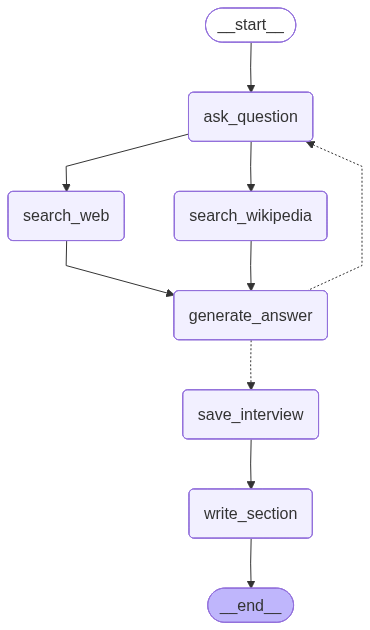

In [96]:
display(Image(interview_graph.get_graph().draw_mermaid_png()))

In [97]:
analyst

Analyst(name='Jordan Okafor', role='Applied AI Product Manager (Enterprise Applications)', affiliation='Enterprise software vendor / internal AI apps team', description='Focuses on the latest enterprise application patterns enabled by LangGraph: multi-agent collaboration, workflow automation across systems of record (CRM/ERP/ITSM), customer support copilots, research/analysis agents, and back-office process automation. Judges benefits in terms of time-to-value, reliability of outcomes, user trust (explanations/trace views), and how graph-based design maps to real business processes and SLAs.')

In [98]:
analyst.persona

'Name: Jordan Okafor\nRole: Applied AI Product Manager (Enterprise Applications)\nAffiliation: Enterprise software vendor / internal AI apps team\nDescription: Focuses on the latest enterprise application patterns enabled by LangGraph: multi-agent collaboration, workflow automation across systems of record (CRM/ERP/ITSM), customer support copilots, research/analysis agents, and back-office process automation. Judges benefits in terms of time-to-value, reliability of outcomes, user trust (explanations/trace views), and how graph-based design maps to real business processes and SLAs.\n'

In [99]:
thread = {"configurable": {"thread_id": "1"}}

In [100]:
from IPython.display import Markdown

In [101]:
messages = [HumanMessage("So you said you were writing an article on Langchain?")]

In [102]:
interview = interview_graph.invoke({"analyst": analyst, "messages": messages, "max_num_turns": 2}, thread)

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


*******************************
search_query='article on LangChain LangChain vs LangGraph enterprise applications patterns RAG tool calling evaluation workflows orchestration reliability audit trail'


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


*******************************
search_query='enterprise AI product leader interview question article on LangChain vs LangGraph patterns stateful workflow orchestration loops branching approvals retries audit trail SLAs real enterprise applications'


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


In [103]:
Markdown(interview['sections'][0])

## From Chains to Graphs: LangGraph Patterns for Reliable Multi‑Agent Enterprise Workflows

### Summary
Enterprise LLM applications are rapidly moving beyond “prompt → model → answer” into coordinated workflows that must integrate systems of record (CRM/ERP/ITSM), support human-in-the-loop steps, and meet operational expectations like retries, traceability, and SLAs. The key design shift in the provided sources is the framing of orchestration as **stateful graphs** rather than linear pipelines—better matching how real business processes branch, loop, and recover from partial failures.

Across multiple comparisons, LangChain is consistently positioned as the fastest path for **sequential** use cases (e.g., RAG/document Q&A, summarization, straightforward chatbots, and prototypes) where each run is largely independent and the flow is A→B→C [1][2][3]. Novel in these writeups is a pragmatic “right tool for the job” stance: even advocates note that for very simple RAG loops, teams may prefer **vanilla Python + direct model APIs** to avoid framework overhead—suggesting LangChain’s value is increasingly in enterprise-grade integration breadth and higher-complexity orchestration rather than being mandatory middleware for every app [4].

Where LangGraph becomes compelling—and most aligned with enterprise patterns—is in **multi-agent collaboration and long-running, non-linear workflows**: explicit state objects passed node-to-node, branching approvals, retries without restarting entire runs (saving cost and time), and even parallel execution with merges [1][2][5]. This directly maps to back-office automations (e.g., exception handling, validation loops) and customer support copilots that must hold context across turns and tool calls.

A second enterprise-relevant insight is the emphasis on **observability and trust**. Sources argue that LangGraph’s graph structure can provide step-level traceability of transitions and state changes—especially when paired with tooling like LangSmith—improving auditability and debugging versus “glue code” around linear chains [6][2]. That’s a concrete path toward user-facing explanation/trace views and operational confidence.

Finally, several sources converge on a **composable pattern**: use LangChain for its ecosystem (connectors, prompt tooling, vector store integrations, LCEL pipelines), then layer LangGraph to orchestrate the overall state machine when requirements evolve into loops, branching, or multiple cooperating agents [3][7]. This “components + graph control plane” approach is a practical time-to-value strategy for enterprises: prototype quickly, then harden into reliable graph-based processes as SLAs and governance needs increase.

### Sources
[1] https://www.linkedin.com/posts/hatwar-tushar_langchain-langgraph-llm-activity-7364919296126259201-t1St/  
[2] https://duplocloud.com/blog/langchain-vs-langgraph/  
[3] https://milvus.io/blog/langchain-vs-langgraph.md  
[4] https://github.com/orgs/community/discussions/182015  
[5] https://www.linkedin.com/posts/leadgenmanthan_langchain-is-dead-for-production-not-activity-7368138685487243265-yuAU/  
[6] https://medium.com/@sachinsoni600517/langchain-vs-langgraph-430a8a16566e  
[7] https://sparkco.ai/blog/langgraph-vs-langchain-deep-dive-into-advanced-nlp-orchestration  

## third Workflow